# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [22]:
# Load the Drive helper and mount
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%cd /content/drive/My\ Drive/Git_Repos/Udacity/aipnd-project


/content/drive/My Drive/Git_Repos/Udacity/aipnd-project


In [24]:
# Imports here
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import copy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights



print(torch.__version__)

2.4.1+cu121


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [25]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [26]:
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

--2024-10-07 15:53:15--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.192.95, 52.216.209.96, 52.217.45.190, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.192.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz.6’

flower_data.tar.gz. 100%[===================>] 328.90M  1.63MB/s    in 3m 48s  

2024-10-07 15:57:03 (1.45 MB/s) - ‘flower_data.tar.gz.6’ saved [344873452/344873452]

unlink: cannot unlink 'flowers': Is a directory
mkdir: cannot create directory ‘flowers’: File exists


In [27]:
# Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

#  Using the image datasets and the trainforms, define the dataloaders

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=2, pin_memory=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=2, pin_memory=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
}


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [28]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [29]:
# Using a smaller pre-trained model ResNet18
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)


# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Define the final fully connected layer for classification
model.fc = nn.Sequential(
    nn.Linear(512, 256),     # First fully connected layer: input is 512 features, output is 256 features

    nn.ReLU(), # ReLU activation function to introduce non-linearity

    nn.Dropout(0.2), # Dropout layer with 20% probability to prevent overfitting

    nn.Linear(256, 102),     # Second fully connected layer: input is 256 features, output is 102 classes (flower species)

    nn.LogSoftmax(dim=1)     # LogSoftmax activation: converts output to log probabilities for 102 classes

)

print('model loaded')

model loaded


In [30]:

# Define the loss function (Negative Log-Likelihood Loss) suitable for classification tasks with LogSoftmax
criterion = nn.NLLLoss()

# Define the optimizer (Adam) to optimize the model's fully connected layer (model.fc)
# The learning rate is set to 0.003 for efficient convergence
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Use a learning rate scheduler to reduce the learning rate when a metric (validation loss) stops improving
# 'ReduceLROnPlateau' decreases the learning rate by a factor of 0.1 if validation loss doesn't improve for 3 epochs (patience)
# mode='min' because we want to minimize the validation loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

True


In [32]:
# function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    """
    Train the model with early stopping and learning rate scheduling.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function (e.g., NLLLoss).
        optimizer (torch.optim.Optimizer): The optimizer (e.g., Adam) used to update the model parameters.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler that adjusts the learning rate based on validation loss.
        num_epochs (int): The maximum number of epochs to train the model (default: 10).
        patience (int): The number of epochs to wait for improvement before early stopping (default: 3).

    Returns:
        model (torch.nn.Module): The trained model with the best weights (based on validation accuracy).
    """

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            print(f"{phase} in epoch {epoch +1} ")
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Adjust learning rate using scheduler after validation
            if phase == 'valid':
                scheduler.step(epoch_loss)  # Pass validation loss to scheduler

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improve_epochs = 0
            elif phase == 'valid':
                no_improve_epochs += 1

        print()

        # Early stopping
        if no_improve_epochs >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


# update criterion  on the correct device
criterion = criterion.to(device)

# Move model to the appropriate device
model = model.to(device)

# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=3)

print("Training complete!")

Epoch 1/10
----------
train in epoch 1 
train Loss: 3.1166 Acc: 0.3017
valid in epoch 1 
valid Loss: 1.2622 Acc: 0.6895

Epoch 2/10
----------
train in epoch 2 
train Loss: 1.5665 Acc: 0.5846
valid in epoch 2 
valid Loss: 0.7358 Acc: 0.8166

Epoch 3/10
----------
train in epoch 3 
train Loss: 1.2325 Acc: 0.6587
valid in epoch 3 
valid Loss: 0.6072 Acc: 0.8411

Epoch 4/10
----------
train in epoch 4 
train Loss: 1.0796 Acc: 0.6998
valid in epoch 4 
valid Loss: 0.4971 Acc: 0.8790

Epoch 5/10
----------
train in epoch 5 
train Loss: 0.9691 Acc: 0.7346
valid in epoch 5 
valid Loss: 0.4725 Acc: 0.8680

Epoch 6/10
----------
train in epoch 6 
train Loss: 0.9418 Acc: 0.7384
valid in epoch 6 
valid Loss: 0.4406 Acc: 0.8814

Epoch 7/10
----------
train in epoch 7 
train Loss: 0.9370 Acc: 0.7401
valid in epoch 7 
valid Loss: 0.3718 Acc: 0.9108

Epoch 8/10
----------
train in epoch 8 
train Loss: 0.8760 Acc: 0.7491
valid in epoch 8 
valid Loss: 0.4074 Acc: 0.8900

Epoch 9/10
----------
train in e

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [33]:
def test_model(model, criterion, dataloader):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    total = 0

    # Turn off gradients for validation to save memory and computations
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    # Compute loss and accuracy
    test_loss = running_loss / total
    test_acc = running_corrects.double() / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    return test_loss, test_acc


# Assuming you already have your test dataloader
test_loss, test_acc = test_model(model, criterion, dataloaders['test'])


Test Loss: 0.4375, Test Accuracy: 0.8852


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [34]:
def save_checkpoint(model, optimizer, epochs, file_path='checkpoint.pth'):
    # Add class to index mapping to the model for inference
    model.class_to_idx = image_datasets['train'].class_to_idx

    # Create a dictionary to save all the necessary information
    checkpoint = {
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'class_to_idx': model.class_to_idx,
        'model_architecture': 'resnet18'  # You can store the architecture if needed
    }

    # Save the checkpoint
    torch.save(checkpoint, file_path)
    print(f'Model saved to {file_path}')

save_checkpoint(model, optimizer, epochs=10, file_path='resnet18_checkpoint.pth')

Model saved to resnet18_checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [35]:
def load_checkpoint(filepath):
    # Load the checkpoint from the file
    checkpoint = torch.load(filepath, weights_only=True)

    # Rebuild the model architecture (based on ResNet18 in this case)
    model = models.resnet18(pretrained=True)

    # Modify the final fully connected layer to match the number of classes
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, len(checkpoint['class_to_idx'])),
        nn.LogSoftmax(dim=1)
    )

    # Load the model state dictionary from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']

    # Load the optimizer state to continue training
    #optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load the epoch (useful if continuing training)
    epoch = checkpoint['epoch']

    print(f"Checkpoint loaded: Model architecture is ResNet18, trained for {epoch} epochs.")

    return model, optimizer, epoch

model, optimizer, epoch = load_checkpoint('resnet18_checkpoint.pth')
print("Model, optimizer, and epoch loaded successfully.")


Checkpoint loaded: Model architecture is ResNet18, trained for 10 epochs.
Model, optimizer, and epoch loaded successfully.


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [36]:
def process_image(image_path):
    '''Scales, crops, and normalizes a PIL image for a PyTorch model, returns a Numpy array.'''
    # Open the image
    image = Image.open(image_path).convert("RGB")  # Ensure the image has 3 channels (RGB)

    # Define the transformations
    preprocess = transforms.Compose([
        transforms.Resize(256),  # Resize shortest side to 256
        transforms.CenterCrop(224),  # Crop to 224x224 in the center
        transforms.ToTensor(),  # Convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ])

    # Apply the transformations
    image = preprocess(image)

    return image.numpy()  # Convert to numpy array for processing


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [37]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [38]:

def predict(image_path, model, topk=5):
    '''Predict the top K classes of an image using a trained deep learning model.'''
    # Process the image for the model
    image = process_image(image_path)

    # Convert to Tensor
    image_tensor = torch.from_numpy(image).unsqueeze(0)  # Add batch dimension

    # Set model  in evaluation mode
    model.eval()
    #move the image to the appropriate device (GPU/CPU)
    image_tensor = image_tensor.to(next(model.parameters()).device)

    # Disable gradient calculation for inference
    with torch.no_grad():
        output = model(image_tensor)

    # Get the probabilities by applying softmax to the model output
    probs = torch.exp(output)

    # Get the top K probabilities and classes
    top_probs, top_classes = probs.topk(topk, dim=1)

    # Convert to numpy arrays for easy use
    top_probs = top_probs.cpu().numpy().squeeze()
    top_classes = top_classes.cpu().numpy().squeeze()

    # Get the class-to-index mapping and reverse it to map indices back to class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[i] for i in top_classes]

    return top_probs, top_classes


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

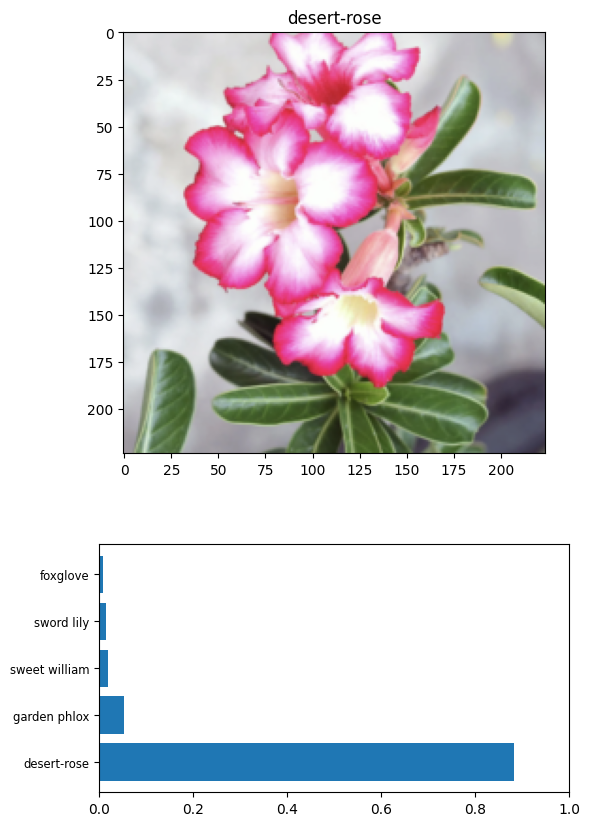

In [39]:
def sanity_check(image_path, model, topk=5):
    """Display an image along with the top K predicted flower names and probabilities."""
    # Get the top K predictions using the predict function
    probs, classes = predict(image_path, model, topk=topk)

    # Convert the class indices to names
    flower_names = [cat_to_name[str(cls)] for cls in classes]

    # Plot the image
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)

    # Display the input image
    image = process_image(image_path)
    image_tensor = torch.from_numpy(image)
    imshow(image_tensor, ax=ax1)

    # Set the title of the image as the top predicted class (most likely flower)
    ax1.set_title(flower_names[0])

    # Plot the probabilities as a bar graph
    ax2.barh(flower_names, probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(flower_names)))
    ax2.set_yticklabels(flower_names, size='small')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

image_path = 'flower_dr.png'
sanity_check(image_path, model)



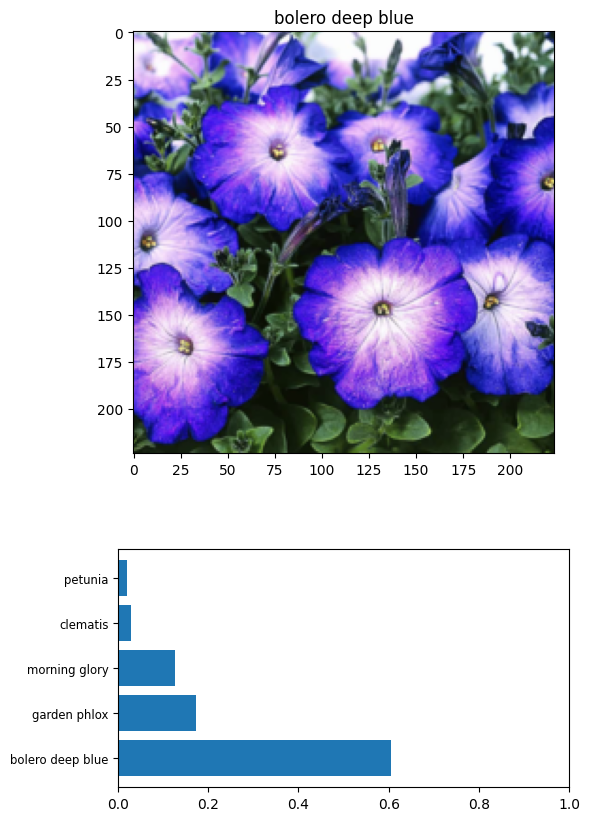

In [40]:
image_path = 'flower_pt.png'
sanity_check(image_path, model)

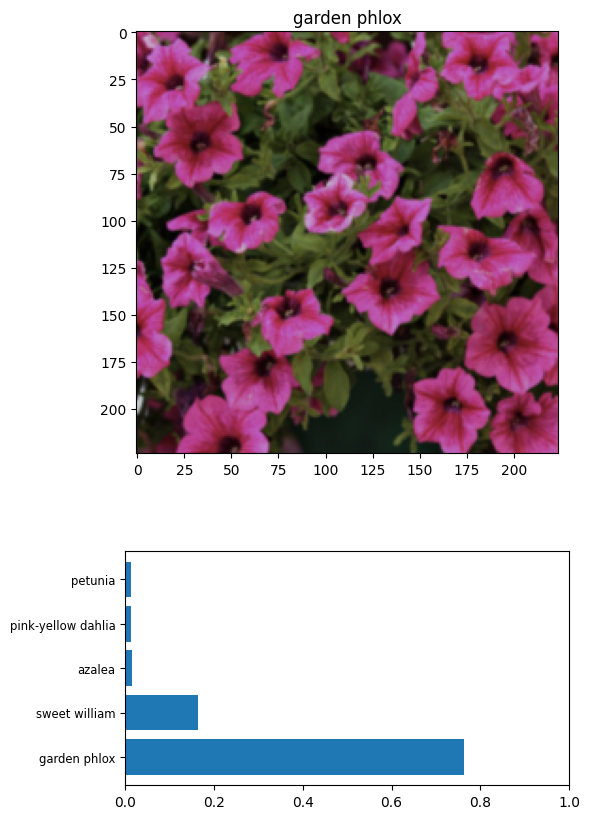

In [41]:
image_path = 'flower_pt1.png'
sanity_check(image_path, model)

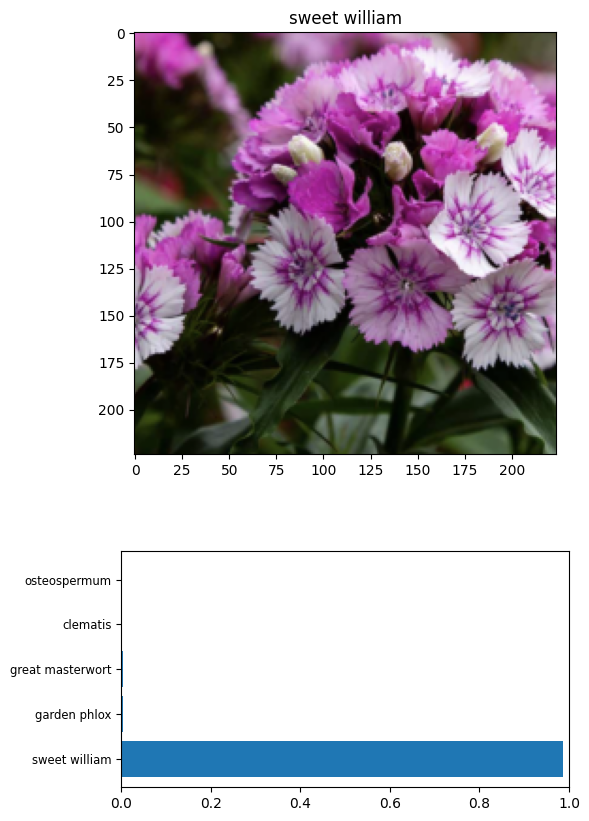

In [42]:
image_path = 'flower_sweet.png'
sanity_check(image_path, model)